<a href="https://colab.research.google.com/github/Tej-55/SAiDL-Summer-Assignment-2023-NLP/blob/main/CMI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install googletrans==3.1.0a0    # Uncomment this cell for the text generation
#from googletrans import Translator

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import random

In [ ]:
!pip install tensorflow_text
import tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 52.0 MB/s eta 0:00:00


# Data Generation
Here, I've generated for 20%, 40%, 60%, 80% cmi in the text. I'm going to save these dataframe, because they take a lot of time to generate each time.

In [ ]:
orig_df = pd.read_csv("hindi_dataset.xlsx - hindi_dataset.csv")

In [ ]:
orig_df

,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE
...,...,...,...,...,...
4660,hasoc_hi_6606,पाकिस्तान ने हिंदुओं के ख़िलाफ़ बोलने वाले को ...,NOT,NONE,NONE
4661,hasoc_hi_4931,कोहली है #नेहरू नहीं जो अंग्रेजों के तलवे चाटन...,HOF,PRFN,TIN
4662,hasoc_hi_1059,परशुराम? वही जिसने अपनी मां की हत्या की थीं?,NOT,NONE,NONE
4663,hasoc_hi_5429,जिस देश में #कन्हैया_कुमार जैसा पढ़ा लिखा युवा...,HOF,HATE,TIN


In [ ]:
translator = Translator()
translator.translate(orig_df.text[0]).text

'Great comeback of Bangladesh, stopped India for 314 runs #INDvBAN #CWC19'

In [ ]:
def generate_cmi(text, cmi):
  w = text.split()
  for i in random.sample(range(len(w)), int(len(w)*cmi)):
    w[i] = translator.translate(w[i]).text
  return " ".join(w)

In [ ]:
cmi_list = [0.2, 0.4, 0.6, 0.8]
df_dict = dict()
for cmi in cmi_list:
  df_dict[f'df_cmi_{cmi}'] = pd.DataFrame()
  df_dict[f'df_cmi_{cmi}']['text'] = orig_df['text'].apply(lambda x: generate_cmi(x,cmi))
  df_dict[f'df_cmi_{cmi}']["task_1"] = orig_df["task_1"]
  df_dict[f'df_cmi_{cmi}'].to_csv(f"df_cmi_{cmi}.csv")
  print(f"Dataframe with cmi {cmi} done.")
print("All done.")

# Loading Pre-generated Data

In [ ]:
df_dict = dict()
cmi_list = [0.2, 0.4, 0.6, 0.8]
for cmi in cmi_list:
  df_dict[f'df_cmi_{cmi}'] = pd.read_csv(f'df_cmi_{cmi}.csv')
  df_dict[f'df_cmi_{cmi}']['HOF'] = df_dict[f'df_cmi_{cmi}']['task_1'] == 'HOF'

In [ ]:
df_dict[f'df_cmi_0.4']

,Unnamed: 0,text,task_1,HOF
0,0,"बांग्लादेश की शानदार वापसी, भारत को 314 Run पर...",NOT,False
1,1,All whore नाच देखने In Busy जैसे only कोई #शां...,HOF,True
2,2,तुम जैसे हरामियों Of For बस जूतों की कमी है शु...,HOF,True
3,3,"बीजेपी MLA आकाश विजयवर्गीय Jail से released, B...",NOT,False
4,4,चमकी बुखार: Assembly premises में आरजेडी का प्...,NOT,False
...,...,...,...,...
4660,4660,Pakistan has हिंदुओं के ख़िलाफ़ to speak वाले ...,NOT,False
4661,4661,कोहली है #नेहरू नहीं जो British के तलवे to lic...,HOF,True
4662,4662,परशुराम? वही Whosoever Own मां की हत्या की Was...,NOT,False
4663,4663,That देश In #kanhaiya_kumar जैसा पढ़ा wrote Yo...,HOF,True


In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 32

for cmi in cmi_list:
  df_dict[f'train_df_{cmi}'], df_dict[f'test_df_{cmi}'] = train_test_split(df_dict[f'df_cmi_{cmi}'], random_state=42, train_size=0.7, stratify=df_dict[f'df_cmi_{cmi}']['HOF'].values)

with tf.device('/cpu:0'):
  for cmi in cmi_list:
    df_dict[f'train_data_{cmi}'] = tf.data.Dataset.from_tensor_slices((df_dict[f'train_df_{cmi}']['text'], df_dict[f'train_df_{cmi}']['HOF'])).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    df_dict[f'test_data_{cmi}'] = tf.data.Dataset.from_tensor_slices((df_dict[f'test_df_{cmi}']['text'], df_dict[f'test_df_{cmi}']['HOF'])).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
df_dict[f'train_data_0.4']

<_PrefetchDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.bool, name=None))>

#BERT Model
Here I'm using TensorFlow Hub to import [bert_en_cased_L-12_H-768_A-12](https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4).

In [ ]:

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4", trainable=True)

def make_bert():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  encoder_inputs = preprocessor(text_input)
  outputs = encoder(encoder_inputs)
  drop = tf.keras.layers.Dropout(0.4)(outputs["pooled_output"])
  output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
  return tf.keras.Model(inputs=text_input, outputs=output)

model_bert = make_bert()

In [ ]:
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

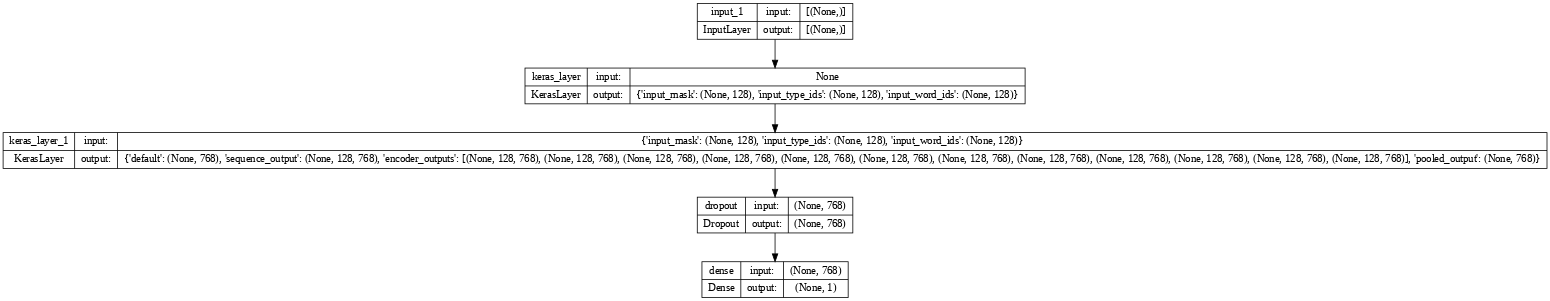

In [ ]:
tf.keras.utils.plot_model(model=model_bert, show_shapes=True, dpi=56)

In [ ]:
epochs = 3
bert_train = dict() # contains elements as form: {0.4 : (model, history)}

for cmi in cmi_list:
  model = make_bert()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
  history = model.fit(df_dict[f'train_data_{cmi}'], validation_data=df_dict[f'test_data_{cmi}'], epochs=epochs, verbose=1)
  bert_train[cmi] = (model, history)
  print(f'\n================ CMI {cmi} training COMPLETED ================\n')

Epoch 1/3
102/102 [==============================] - 151s 996ms/step - loss: 0.6751 - binary_accuracy: 0.6225 - val_loss: 0.5891 - val_binary_accuracy: 0.6831
Epoch 2/3
102/102 [==============================] - 100s 985ms/step - loss: 0.5886 - binary_accuracy: 0.6814 - val_loss: 0.5155 - val_binary_accuracy: 0.7435
Epoch 3/3
102/102 [==============================] - 102s 1s/step - loss: 0.4758 - binary_accuracy: 0.7693 - val_loss: 0.5310 - val_binary_accuracy: 0.7456

================ CMI 0.2 training COMPLETED ================

Epoch 1/3
102/102 [==============================] - 138s 1s/step - loss: 0.4689 - binary_accuracy: 0.7782 - val_loss: 0.5412 - val_binary_accuracy: 0.7594
Epoch 2/3
102/102 [==============================] - 101s 995ms/step - loss: 0.3347 - binary_accuracy: 0.8505 - val_loss: 0.6646 - val_binary_accuracy: 0.7587
Epoch 3/3
102/102 [==============================] - 102s 997ms/step - loss: 0.2417 - binary_accuracy: 0.8974 - val_loss: 0.7463 - val_binary_accura

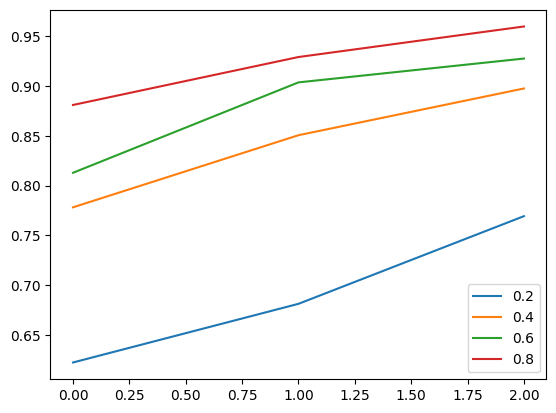

In [ ]:
for cmi in cmi_list:
  _, history = bert_train[cmi]
  plt.plot(history.history['binary_accuracy'])
plt.legend(cmi_list, loc='lower right')

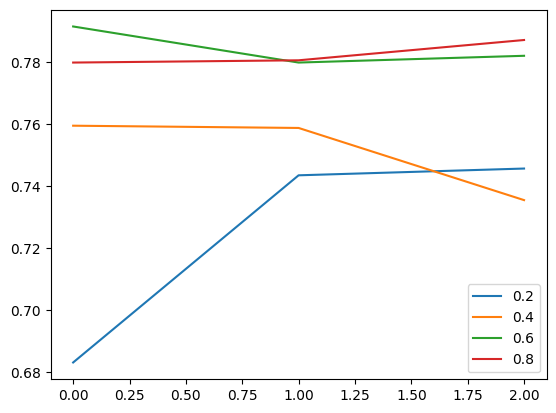

In [ ]:
for cmi in cmi_list:
  _, history = bert_train[cmi]
  plt.plot(history.history['val_binary_accuracy'])
plt.legend(cmi_list, loc='lower right')

#m-BERT Model
Here I'm using TensorFlow Hub to import [bert_multi_cased_L-12_H-768_A-12](https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4).


In [ ]:

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)


def make_mbert():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  encoder_inputs = preprocessor(text_input)
  outputs = encoder(encoder_inputs)
  drop = tf.keras.layers.Dropout(0.4)(outputs["pooled_output"])
  output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
  return tf.keras.Model(inputs=text_input, outputs=output)

model_mbert = make_mbert()

In [ ]:
df_dict[f'train_data_0.4']

<_PrefetchDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.bool, name=None))>

In [ ]:
model_mbert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_mbert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

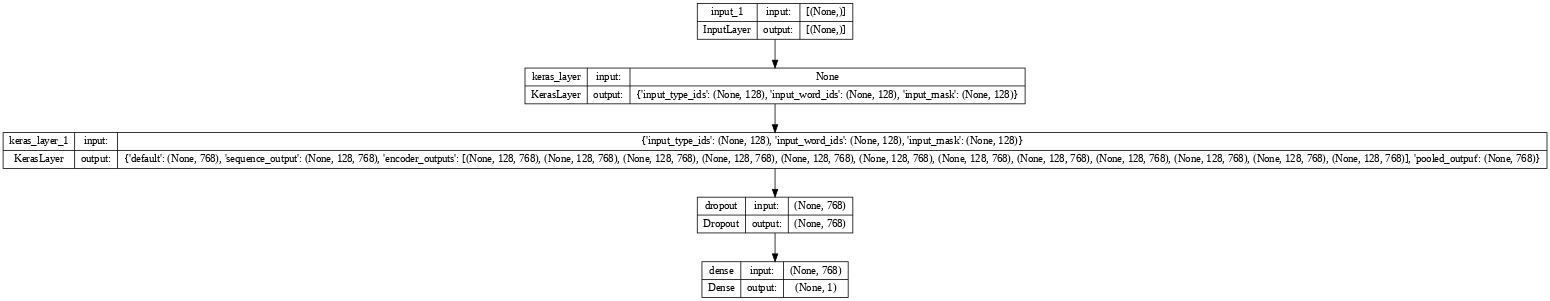

In [ ]:
tf.keras.utils.plot_model(model=model_mbert, show_shapes=True, dpi=56)

In [ ]:
epochs = 3
mbert_train = dict() # contains elements as form: {0.4 : (model, history)}

for cmi in cmi_list:
  model = make_mbert()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
  history = model.fit(df_dict[f'train_data_{cmi}'], validation_data=df_dict[f'test_data_{cmi}'], epochs=epochs, verbose=1)
  mbert_train[cmi] = (model, history)
  print(f'\n================ CMI {cmi} training COMPLETED ================\n')

Epoch 1/3
102/102 [==============================] - 152s 1s/step - loss: 0.5756 - binary_accuracy: 0.6924 - val_loss: 0.4351 - val_binary_accuracy: 0.7914
Epoch 2/3
102/102 [==============================] - 105s 1s/step - loss: 0.4132 - binary_accuracy: 0.7947 - val_loss: 0.4625 - val_binary_accuracy: 0.8081
Epoch 3/3
102/102 [==============================] - 107s 1s/step - loss: 0.2988 - binary_accuracy: 0.8631 - val_loss: 0.5615 - val_binary_accuracy: 0.8212

================ CMI 0.2 training COMPLETED ================

Epoch 1/3
102/102 [==============================] - 141s 1s/step - loss: 0.3610 - binary_accuracy: 0.8321 - val_loss: 0.5130 - val_binary_accuracy: 0.8190
Epoch 2/3
102/102 [==============================] - 106s 1s/step - loss: 0.2673 - binary_accuracy: 0.8848 - val_loss: 0.4867 - val_binary_accuracy: 0.8190
Epoch 3/3
102/102 [==============================] - 107s 1s/step - loss: 0.1985 - binary_accuracy: 0.9210 - val_loss: 0.5230 - val_binary_accuracy: 0.7972



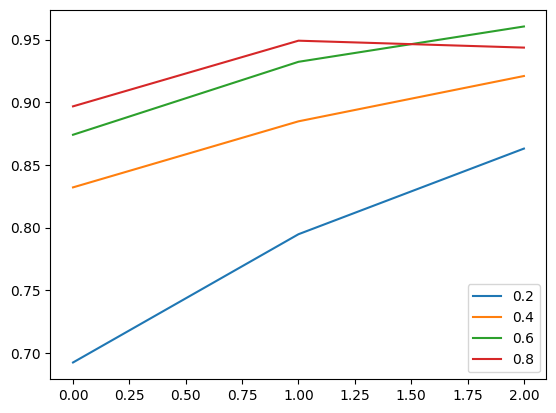

In [ ]:
for cmi in cmi_list:
  _, history = mbert_train[cmi]
  plt.plot(history.history['binary_accuracy'])
plt.legend(cmi_list, loc='lower right')

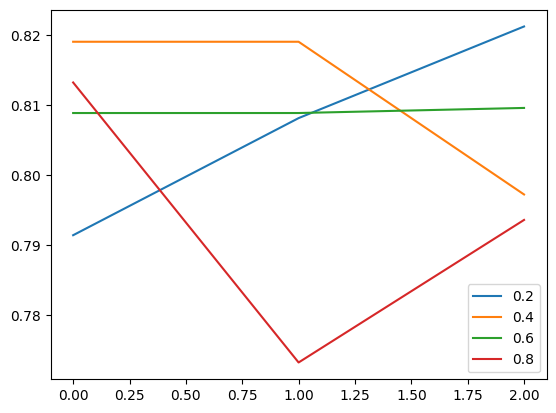

In [ ]:
for cmi in cmi_list:
  _, history = mbert_train[cmi]
  plt.plot(history.history['val_binary_accuracy'])
plt.legend(cmi_list, loc='lower right')